In [1]:
from google.colab import drive
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = '/content/drive/My Drive/GENETIC/data/'

In [3]:
def createBinaryValuesInitial():
  for i, day in enumerate(days):
    binaryValues['days'][day] = bin(i)[2:]
    decodeValues['days'][bin(i)[2:]] = day
  for i, timing in enumerate(timings):
    binaryValues['timings'][timing] = bin(i)[2:]
    decodeValues['timings'][bin(i)[2:]] = timing
  for i, classroom in enumerate(classrooms):
    binaryValues['classrooms'][classroom] = bin(i)[2:]
    decodeValues['classrooms'][bin(i)[2:]] = classroom
def createBinaryValuesdata(data, typeData):
  for i, value in enumerate(data):
    binaryValues[typeData][value] = bin(i)[2:]
    decodeValues[typeData][bin(i)[2:]] = value

In [4]:
def createDate():
  def createStudentUnitRelationship():
    students = []
    student_units = open(PATH + 'student_units.csv').readlines()[1:]
    for lines in student_units:
      data = lines.split(',')
      students.append(data[0])
      try:
        unitsStudents[data[2][:-1]].append(data[0])
      except:
        unitsStudents[data[2][:-1]] = []
        unitsStudents[data[2][:-1]].append(data[0])
    createBinaryValuesdata(students, 'students')
  def getTutorNames():
    tutorNames = []
    tutorfile = open(PATH + 'tutor.csv').readlines()
    for lines in tutorfile:
      tutorNames.append(lines[:-1])
    createBinaryValuesdata(tutorNames, 'tutors')
    return tutorNames[1:]
  def getUnitNames():
    unitCodes = []
    tutorfile = open(PATH + 'units.csv').readlines()[1:]
    for line in tutorfile:
      unitCodes.append(line.split(',')[0])
    createBinaryValuesdata(unitCodes, 'units')
    return unitCodes
  units = getUnitNames()
  createBinaryValuesInitial()
  students = createStudentUnitRelationship()
  tutor = getTutorNames()
  return units, tutor, students
def getMultiple(a, b):
  return b * round(a/b)

In [5]:
def getRandom(array):
  return array[random.randint(0, len(array)-1)]
def generatePopulation():
  exams = []
  for day in days:
    for timing in timings:
      for i in range(0, int(getMultiple(len(units), 5)/5)):
        exams.append([day, timing, getRandom(classrooms), getRandom(units), getRandom(tutor)])
  return exams
def decodeBinaryExam(exam):
  listedExams = []
  exam = exam[:-2]
  allExams = exam.split('|')
  for singleExam in allExams:
    oneListExam = []
    entities = singleExam.split('-')
    oneListExam.append(decodeValues['days'][entities[0]])
    oneListExam.append(decodeValues['timings'][entities[1]])
    oneListExam.append(decodeValues['classrooms'][entities[2]])
    oneListExam.append(decodeValues['units'][entities[3]])
    oneListExam.append(decodeValues['tutors'][entities[4]])
    listedExams.append(oneListExam)
  return listedExams
def convertToBinary(array):
  to_return = ''
  to_return += binaryValues['days'][array[0]]
  to_return += '-'
  to_return += binaryValues['timings'][array[1]]
  to_return += '-'
  to_return += binaryValues['classrooms'][array[2]]
  to_return += '-'
  to_return += binaryValues['units'][array[3]]
  to_return += '-'
  to_return += binaryValues['tutors'][array[4]]
  to_return += '|'
  return to_return
def convertPopToBinary(array):
  to_return = ''
  for data in array:
    to_return += (convertToBinary(data))
  to_return += ('|')
  return to_return
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def SortExams(tup):
    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):
        for j in range(0, lst-i-1):
            if (tup[j][1] < tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup

In [6]:
def crossOver(A, B):
  DataA = decodeBinaryExam(A)
  DataB = decodeBinaryExam(B)
  newDataA = []
  newDataB = []
  newDataA = DataA[:50]
  for data in DataB[50:]:
    newDataA.append(data)
  newDataB = DataB[:50]
  for data in DataA[50:]:
    newDataB.append(data)
  return convertPopToBinary(newDataA),convertPopToBinary(newDataB) 
def mutate(Exam, MutationRate):
  # print(MutationRate)
  Exam = decodeBinaryExam(Exam)
  RandomPopulation  = generatePopulation()
  finalPopulation = []
  for dataExam, randomData in zip(Exam, RandomPopulation):
    geneMutationRate = random.uniform(0,1)
    if geneMutationRate < MutationRate:
      finalPopulation.append(dataExam)
    else:
      finalPopulation.append(randomData)
  return convertPopToBinary(finalPopulation)
def covertBackToPopulation(popA, popB, sorted_Exams):
  sorted_Exams.append(popA)
  sorted_Exams.append(popB)
  sorted_Exams = SortExams(sorted_Exams)
  del sorted_Exams[5]
  del sorted_Exams[5]
  return sorted_Exams

In [7]:
def calculateFitness(exam):
  fitness = 0
  data = decodeBinaryExam(exam)
  dictionaryOfExams = {}
  timings = ['morning', 'evening']
  days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
  unitsVisited = set([])
  studentsVisited = set([])
  tutorDuty = {}
  # ['monday', 'morning', 'P411', 'CIS318', 'Tutor23']

  for day in days:
    dictionaryOfExams[day] = {}
    for time in timings: 
      dictionaryOfExams[day][time] = []
  for examslot in data:
    dictionaryOfExams[examslot[0]][examslot[1]].append(examslot)
    try:
      tutorDuty[examslot[4]] += 1
    except:
      tutorDuty[examslot[4]] = 0
    if examslot[4] == '':
      # it shows there is no tutor in that exam slot
      fitness -= 3
    if examslot[0] == 'saturday' or examslot[0] == 'sunday':
      fitness -= 3
    if examslot[1] not in timings:# if timing not in morning or evening
      fitness -= 3
    unitsVisited.add(examslot[3])
  for day in days:
    tutorVisted = []
    studentsInMorning = []
    studentsInEvening = []
    for examslot in dictionaryOfExams[day]['morning']:
      try:
        studentsInExam = unitsStudents[examslot[3]]
        for student in studentsInExam:
          if student not in studentsInMorning:
            studentsInMorning.append(student)
          else:
            fitness -= 3 #because there already exist a student in that session
      except:
        pass
      if examslot[4] not in tutorVisted:
        tutorVisted.append(examslot[4])
      else:
        fitness -= 3 #because there already exist that tutor for another exam in that session
    tutorVisted = []
    for examslot in dictionaryOfExams[day]['evening']:
      try:
        studentsInExam = unitsStudents[examslot[3]]
        for student in studentsInExam:
          if student not in studentsInEvening:
            studentsInEvening.append(student)
          else:
            fitness -= 3 #because there already exist a student in that session
      except:
        pass
      if examslot[4] not in tutorVisted:
        tutorVisted.append(examslot[4])
      else:
        fitness -= 3 #because there already exist that tutor for another exam in that session
    fitness -= (len(intersection(studentsInMorning, studentsInEvening)) * 3)
  fitness -= (len(units) - len(unitsVisited)) *3
  tutorDuties = []
  for key, value in tutorDuty.items():
    tutorDuties.append(value)
  np.array(tutorDuties)
  fitness -= abs(np.sum(np.diff(tutorDuties)))*3 #this is to get average difference in the tutor Duties, so that they can be managed effectively. 
  return fitness
def generatePandas(decodedFinalPopulation):
  df = pd.DataFrame(decodedFinalPopulation, columns=['Day', 'Session Time', 'Classroom', 'Unit Code', "Tutor Name"])
  df = df.drop_duplicates(subset='Unit Code', keep='first')
  return df

In [8]:
binaryValues = {}
binaryValues['students'] = {}
binaryValues['tutors'] = {}
binaryValues['units'] = {}
binaryValues['days'] = {}
binaryValues['classrooms'] = {}
binaryValues['timings'] = {}
decodeValues = {}
decodeValues['students'] = {}
decodeValues['tutors'] = {}
decodeValues['units'] = {}
decodeValues['days'] = {}
decodeValues['classrooms'] = {}
decodeValues['timings'] = {}
timings = ['morning', 'evening']
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
classrooms = ['P411', 'P412', 'P413', 'P414', 'P415', 'P416', 'P417', 'P418', 'P419', 'P420']
unitsStudents = {}
units, tutor, students = createDate()
exams = []
overAllBestPopulation = []
allBestFitnesses = []
def runGenetic(numberPopulation):
  for i in range(0, numberPopulation):
    exams.append(generatePopulation())
  print("Generated 5 random populations")
  binaryExams = []
  print("Started encoding")
  for exam in exams:
    binaryExams.append(convertPopToBinary(exam))
  Exam_Fitness = []
  print("Calculating Fitness")
  for binExam in binaryExams:
    Exam_Fitness.append((binExam, calculateFitness(binExam)))
  sortedExams = SortExams(Exam_Fitness)
  print("Initial Best Fitness stands at: ", sortedExams[0][1])
  overAllBestPopulation = [sortedExams[0][0], sortedExams[0][1]]
  print("Applying Elitist!")
  populationA = sortedExams[0][0]
  populationB = sortedExams[1][0]
  print("Applying CrossOver!")
  populationA, populationB = crossOver(populationA, populationB)
  print("Applying Mutation!")
  populationA = mutate(populationA, random.uniform(0, 1))
  populationB = mutate(populationB, random.uniform(0, 1))
  print("Calculating Fitness!")
  populationA = (populationA, calculateFitness(populationA))
  populationB = (populationB, calculateFitness(populationB))
  sortedExams = covertBackToPopulation(populationA, populationB, sortedExams)
  if sortedExams[0][1] > overAllBestPopulation[1]:
    overAllBestPopulation = [sortedExams[0][0], sortedExams[0][1]]
  print("Iteration 0 best fitness stands at: ", sortedExams[0][1])

  input("Press Enter to automate the process!")
  for i in range(1, 1001):
    populationA = sortedExams[0][0]
    populationB = sortedExams[1][0]
    populationA, populationB = crossOver(populationA, populationB)
    populationA = mutate(populationA, random.uniform(0, 1))
    populationB = mutate(populationB, random.uniform(0, 1))
    populationA = (populationA, calculateFitness(populationA))
    populationB = (populationB, calculateFitness(populationB))
    sortedExams = covertBackToPopulation(populationA, populationB, sortedExams)
    allBestFitnesses.append(sortedExams[0][1])
    if sortedExams[0][1] == 0:
      print("Optimum Population reached at iteration: ", i)
      overAllBestPopulation = [sortedExams[0][0], sortedExams[0][1]]
      return decodeBinaryExam(overAllBestPopulation[0]), allBestFitnesses
    if sortedExams[0][1] > overAllBestPopulation[1]:
      overAllBestPopulation = [sortedExams[0][0], sortedExams[0][1]]
    if i %50 == 0:
      print("Iteration " + str(i) + " best fitness stands at: ", sortedExams[0][1])

  print("Over all best Fitness stands at: ", overAllBestPopulation[1])
  return decodeBinaryExam(overAllBestPopulation[0]), allBestFitnesses

In [12]:
decodedFinalPopulation, allBestFitnesses = runGenetic(5)

Generated 5 random populations
Started encoding
Calculating Fitness
Initial Best Fitness stands at:  -33
Applying Elitist!
Applying CrossOver!
Applying Mutation!
Calculating Fitness!
Iteration 0 best fitness stands at:  -33
Press Enter to automate the process!1000
Iteration 50 best fitness stands at:  -21
Iteration 100 best fitness stands at:  -18
Iteration 150 best fitness stands at:  -12
Iteration 200 best fitness stands at:  -12
Iteration 250 best fitness stands at:  -12
Iteration 300 best fitness stands at:  -9
Iteration 350 best fitness stands at:  -6
Iteration 400 best fitness stands at:  -3
Iteration 450 best fitness stands at:  -3
Optimum Population reached at iteration:  493


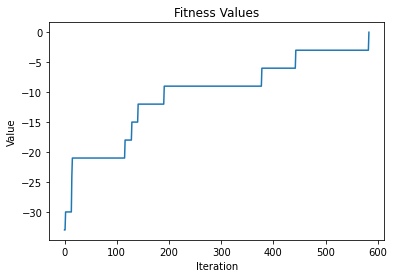

In [10]:
   
plt.plot(allBestFitnesses)
plt.title('Fitness Values')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

In [13]:
df = generatePandas(decodedFinalPopulation)
dt = datetime.now()
ts = datetime.timestamp(dt)
df.to_csv("/content/drive/My Drive/GENETIC/data/timeTable" + str(ts) + '.csv', index = False) 
df

,Day,Session Time,Classroom,Unit Code,Tutor Name
0,monday,morning,P414,CIS332,Tutor29
1,monday,morning,P413,CIS333,Tutor24
2,monday,morning,P417,CIS327,Tutor6
3,monday,morning,P412,CIS315,Tutor26
4,monday,morning,P415,CIS320,Tutor18
5,monday,evening,P412,CIS313,Tutor28
6,monday,evening,P418,CIS316,Tutor9
7,monday,evening,P417,CIS330,Tutor21
8,monday,evening,P414,CIS334,Tutor19
9,monday,evening,P415,CIS335,Tutor26
